In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [12]:
# Cargar el archivo
file_path = 'dataset_con_metadatos.h5'
with h5py.File(file_path, 'r') as f:
    images = np.array(f['images'])  
    sex = np.array(f['sex'])        
    age = np.array(f['age'])        
    #localization = np.array(f['localization'])  
    labels = np.array(f['classification'])  

In [13]:
# Normalizar el metadato edad
scaler = StandardScaler()
age_normalized = scaler.fit_transform(age.reshape(-1, 1))

# One-Hot Encoding para sexo y localización
encoder = OneHotEncoder(sparse_output=False)
sex_encoded = encoder.fit_transform(sex.reshape(-1, 1))
# localization_encoded = encoder.fit_transform(localization.reshape(-1, 1))

# Concatenar los metadatos
metadata = np.concatenate([age_normalized, sex_encoded], axis=1) #Se quitó la localización porque tiene mucahs más filas que los otros metadatos e imágenes

In [10]:
# print(f"Dimensiones de las imágenes: {images.shape}")
# print(f"Dimensiones de la edad: {age_normalized.shape}")
# print(f"Dimensiones del sexo: {sex_encoded.shape}")
# print(f"Dimensiones de la localización: {localization_encoded.shape}")


Dimensiones de las imágenes: (6021, 112, 112, 3)
Dimensiones de la edad: (6021, 1)
Dimensiones del sexo: (6021, 2)
Dimensiones de la localización: (114399, 2)


In [14]:
# Primero, dividir entre entrenamiento (70%) y test+validación (30%)
X_train, X_test, metadata_train, metadata_test, y_train, y_test = train_test_split(
    images, metadata, labels, test_size=0.30, random_state=42)

# Luego dividir la parte test en validación (10%) y prueba (20%)
X_val, X_test, metadata_val, metadata_test, y_val, y_test = train_test_split(
    X_test, metadata_test, y_test, test_size=2/3, random_state=42)

In [26]:
# Definir las dimensiones de las imágenes
image_height, image_width, channels = images.shape[1], images.shape[2], images.shape[3]

# Definir la entrada de imágenes y la CNN
input_img = layers.Input(shape=(image_height, image_width, channels))
x = layers.Conv2D(32, (3, 3), activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Conv2D(64, (3, 3), activation='relu')(x) la saqué porque estaba muy complejo y no podía correrlo
# x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Definir la entrada de metadatos
input_metadata = layers.Input(shape=(metadata_train.shape[1],))
metadata_dense = layers.Dense(64, activation='relu')(input_metadata)

# Combinar las salidas de la CNN y la red densa
combined = layers.concatenate([x, metadata_dense])

# Añadir capas densas finales para la clasificación
z = layers.Dense(64, activation='relu')(combined)
output = layers.Dense(2, activation='softmax')(z)

# Crear el modelo
model_cnn_metadatos1 = models.Model(inputs=[input_img, input_metadata], outputs=output)

# Compilar el modelo con categorical_crossentropy
model_cnn_metadatos1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [25]:
# Entrenar el modelo con una muestra de los datos para probar
history = model_cnn_metadatos1.fit(
    [X_train[:100], metadata_train[:100]], y_train[:100],
    validation_data=([X_val[:20], metadata_val[:20]], y_val[:20]),
    epochs=2, batch_size=32
)

Epoch 1/2


/Users/edgardocrovetto/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_43', 'keras_tensor_49']. Received: the structure of inputs=('*', '*')
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.4769 - loss: 0.9416 - val_accuracy: 0.3500 - val_loss: 0.7074
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5723 - loss: 0.6808 - val_accuracy: 0.6500 - val_loss: 0.6288


In [27]:
# Entrenar el modelo
history = model_cnn_metadatos1.fit(
    [X_train, metadata_train], y_train,
    validation_data=([X_val, metadata_val], y_val),
    epochs=20, batch_size=32
)


Epoch 1/20


/Users/edgardocrovetto/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_54', 'keras_tensor_58']. Received: the structure of inputs=('*', '*')
  warnings.warn(


132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5771 - loss: 1.6844 - val_accuracy: 0.6611 - val_loss: 0.5602
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7056 - loss: 0.5330 - val_accuracy: 0.7226 - val_loss: 0.5046
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.7218 - loss: 0.5088 - val_accuracy: 0.7492 - val_loss: 0.4683
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7467 - loss: 0.4882 - val_accuracy: 0.7425 - val_loss: 0.4725
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7654 - loss: 0.4654 - val_accuracy: 0.7492 - val_loss: 0.4622
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7735 - loss: 0.4398 - val_accuracy: 0.7841 - val_loss: 0.4452
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.7837 - loss: 0.4309 - val_accuracy: 0.7841 - val_loss: 0.4367
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7819 - loss: 0.4289 - val_accuracy: 0.7

In [45]:
# Mostrar el resumen del modelo
model_cnn_metadatos1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 110, 110,  │        896 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 55, 55,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 96800)     │          0 │ max_pooling2d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │        256 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 96864)     │          0 │ flatten_5[0][0],  │
│ (Concatenate)       │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │  6,199,360 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 2)         │        130 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,601,928 (70.96 MB)

 Trainable params: 6,200,642 (23.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,401,286 (47.31 MB)

In [28]:
# Evaluar en el conjunto de prueba
test_loss, test_acc = model_cnn_metadatos1.evaluate([X_test, metadata_test], y_test)
print(f'Accuracy en test: {test_acc:.2f}')


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7907 - loss: 0.4481
Accuracy en test: 0.79


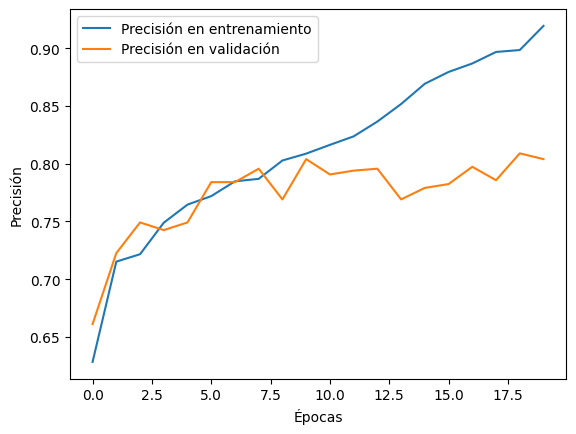

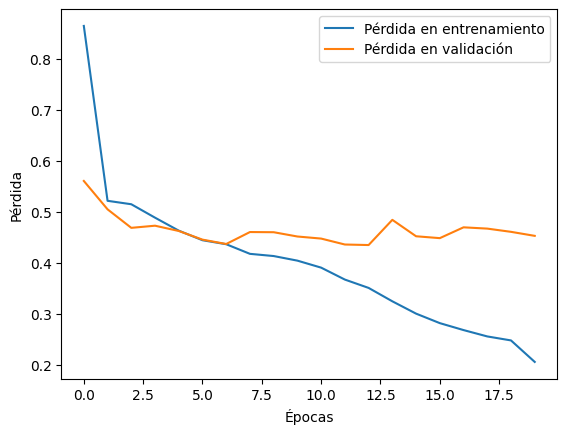

In [29]:
# Curvas de precisión
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Curvas de pérdida
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


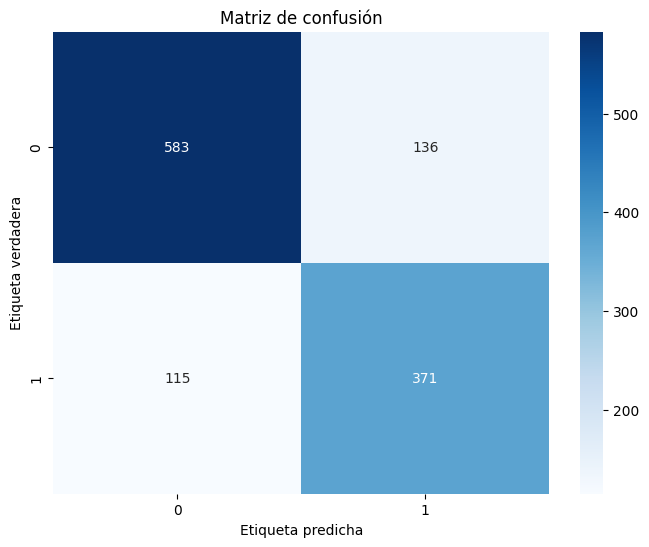

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82       719
           1       0.73      0.76      0.75       486

    accuracy                           0.79      1205
   macro avg       0.78      0.79      0.79      1205
weighted avg       0.79      0.79      0.79      1205

AUC-ROC: 0.87


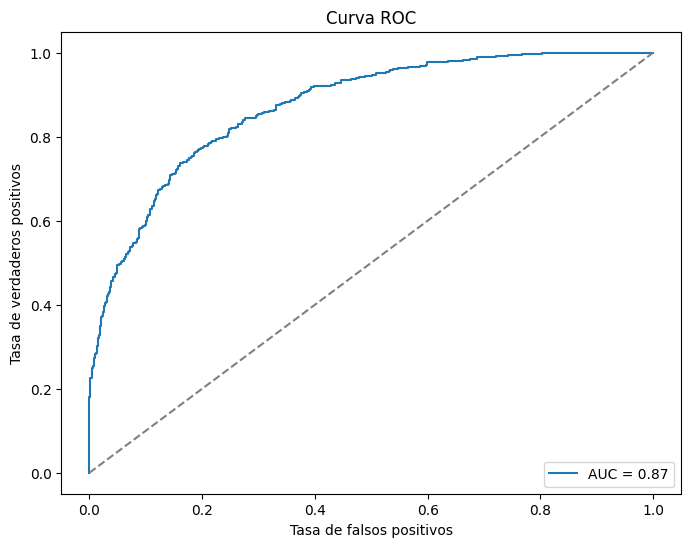

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Predecir en el conjunto de prueba
y_pred = model_cnn_metadatos1.predict([X_test, metadata_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
print("Reporte de clasificación:\n", classification_report(y_true, y_pred_classes))

# Calcular AUC-ROC
y_pred_proba = y_pred[:, 1]
auc = roc_auc_score(y_true, y_pred_proba)
print(f'AUC-ROC: {auc:.2f}')

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

* Nuevo intento ajustando dropout y L2

In [ ]:
from tensorflow.keras import regularizers

# Definir la entrada de imágenes y la CNN
input_img = layers.Input(shape=(image_height, image_width, channels))
x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_img) # Aplicar regularización L2 en capas densas
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)  # Añadir dropout del 30% después de la capa convolucional
x = layers.Flatten()(x)

# Definir la entrada de metadatos
input_metadata = layers.Input(shape=(metadata_train.shape[1],))
metadata_dense = layers.Dense(64, activation='relu')(input_metadata)

# Combinar las salidas de la CNN y la red densa
combined = layers.concatenate([x, metadata_dense])

# Añadir capas densas finales para la clasificación
z = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(combined)
x = layers.Dropout(0.5)(x)  # Dropout del 50% en la capa densa
output = layers.Dense(2, activation='softmax')(z)

# Crear el modelo
model_cnn_metadatos2 = models.Model(inputs=[input_img, input_metadata], outputs=output)

# Compilar el modelo con categorical_crossentropy
model_cnn_metadatos2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)



In [40]:
# Entrenar el modelo

history = model_cnn_metadatos2.fit(
    [X_train, metadata_train], y_train,
    validation_data=([X_val, metadata_val], y_val),
    epochs=20, batch_size=32
)


Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.7867 - loss: 0.4734 - val_accuracy: 0.7841 - val_loss: 0.4796
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7978 - loss: 0.4737 - val_accuracy: 0.7874 - val_loss: 0.4848
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7948 - loss: 0.4726 - val_accuracy: 0.7508 - val_loss: 0.5028
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8018 - loss: 0.4659 - val_accuracy: 0.7774 - val_loss: 0.4876
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.8080 - loss: 0.4538 - val_accuracy: 0.7757 - val_loss: 0.4851
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8129 - loss: 0.4466 - val_accuracy: 0.7940 - val_loss: 0.4727
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8124 - loss: 0.4528 - val_accuracy: 0.7724 - val_loss: 0.4997
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8112 - loss: 0.4474 - v

In [46]:
# Mostrar el resumen del modelo
model_cnn_metadatos2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 110, 110,  │        896 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 55, 55,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 55, 55,    │          0 │ max_pooling2d_11… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 96800)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │        256 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 96864)     │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │  6,199,360 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 2)         │        130 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,601,928 (70.96 MB)

 Trainable params: 6,200,642 (23.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,401,286 (47.31 MB)

In [41]:
# Evaluar en el conjunto de prueba
test_loss, test_acc = model_cnn_metadatos2.evaluate([X_test, metadata_test], y_test)
print(f'Accuracy en test: {test_acc:.2f}')


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7987 - loss: 0.4817
Accuracy en test: 0.80


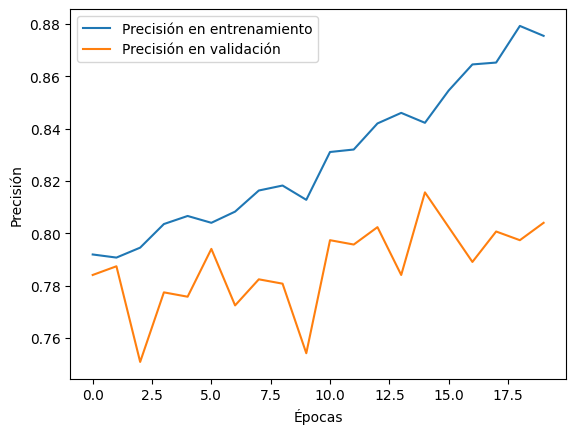

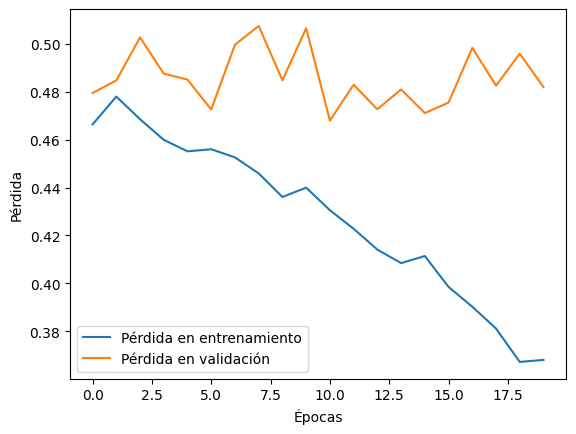

In [42]:
# Curvas de precisión
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Curvas de pérdida
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


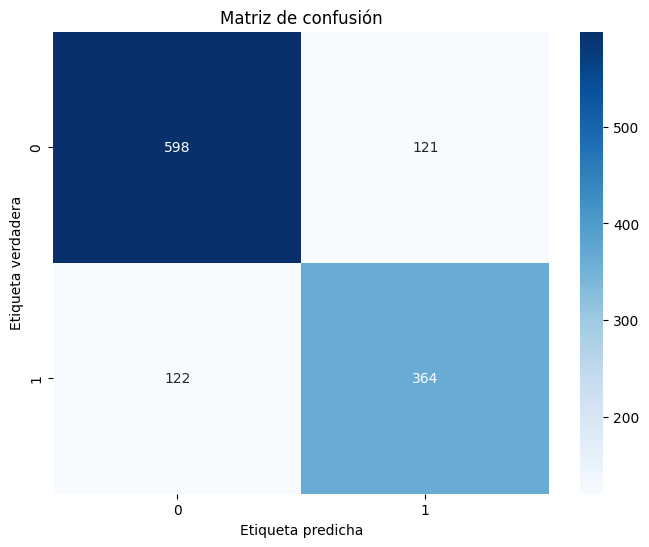

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       719
           1       0.75      0.75      0.75       486

    accuracy                           0.80      1205
   macro avg       0.79      0.79      0.79      1205
weighted avg       0.80      0.80      0.80      1205

AUC-ROC: 0.88


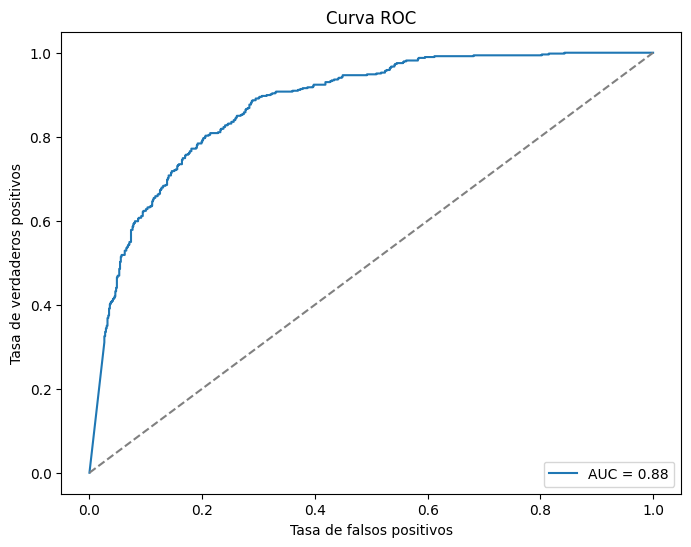

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Predecir en el conjunto de prueba
y_pred = model_cnn_metadatos2.predict([X_test, metadata_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
print("Reporte de clasificación:\n", classification_report(y_true, y_pred_classes))

# Calcular AUC-ROC
y_pred_proba = y_pred[:, 1]
auc = roc_auc_score(y_true, y_pred_proba)
print(f'AUC-ROC: {auc:.2f}')

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()
